In [1]:
from operator import itemgetter
from mytool import uav_traffic_tool
from tests import dataload_example

import numpy as np
import matplotlib.pyplot as plt

tool = uav_traffic_tool.Wiz()

In [2]:
dataset_information={
    'day':'24Oct',
    'month':'10',
    'drone':'2',
    'time_period':'0900_0930',
    'road':'Panepistimiou',
    'intersection':'Panepistimiou-Omirou'
    }

nickname = f'Drone{dataset_information.get('drone')}_{dataset_information.get('day')}_{dataset_information.get('time_period')}'
file_path= fr'C:\Users\kpourg01\Desktop\Work\Code\pNEUMA\datasets\{dataset_information.get('road')}/2018{dataset_information.get('month')}{dataset_information.get('day')[:2]}_d{dataset_information.get('drone')}_{dataset_information.get('time_period')}.csv'

In [3]:
#sampling period must be integer multiple of 0.04
period_dataloading=0.2
time_decimals=1
#===========================================================================================
raw_data = dataload_example.get_info_pneuma(file_path=file_path, sampling_period=period_dataloading, time_decimals=time_decimals, position_smoothing=2)

In [4]:
period_flowcount=1
#----------------------------------------------------
start = min(min(set) for set in raw_data.get('time'))
end = max(max(set) for set in raw_data.get('time'))
time_axis = np.round(np.arange(start,end+period_flowcount,period_flowcount),decimals=time_decimals).tolist()
#----------------------------------------------------
wgs=True
#----------------------------------------------------
ll_lat,ll_lon = 37.97811671602297, 23.733975874806358
lr_lat,lr_lon = 37.97876143771719, 23.735210640421347
ur_lat,ur_lon = 37.97938790250702, 23.734674127747873
ul_lat,ul_lon = 37.97874587304865, 23.73345028699124
#----------------------------------------------------
bbox = [(ll_lat,ll_lon), 
        (lr_lat,lr_lon),
        (ur_lat,ur_lon),
        (ul_lat,ul_lon)]
#----------------------------------------------------
intersection_center=(37.97866950849114, 23.734362398006162)
#----------------------------------------------------
spatio_temporal_info =  {'wgs':wgs,'bbox':bbox,'intersection center':intersection_center,'time axis': time_axis}

In [5]:
dataloader = tool.dataloader(raw_data, spatio_temporal_info)
data = dataloader.get_filtered_data(cursed_ids=[208,1442,75,2450,140,1151,1469,628,2941,154,917,614,682,326,1246,1281,1817,2021,1659,2480,2509])
analysis = tool.analysis(data,spatio_temporal_info)
visualization = tool.visualization(data,spatio_temporal_info)

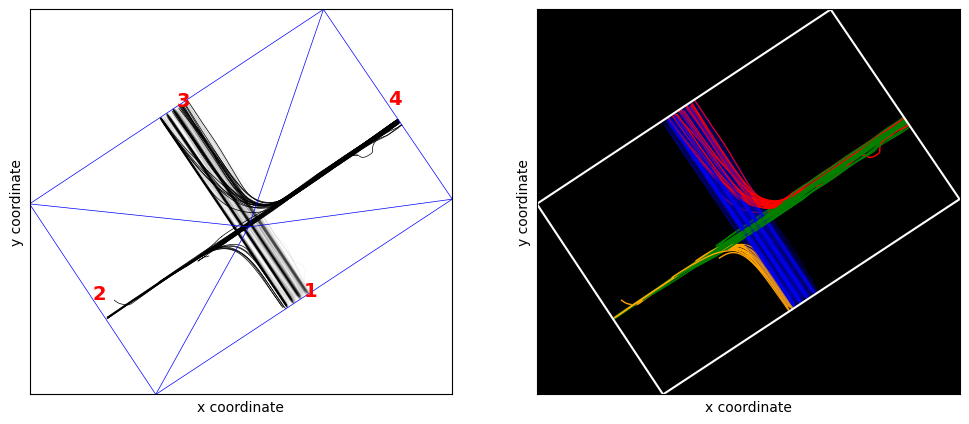

In [6]:
od_pairs = analysis.get_od_pairs()
valid_od_pairs = [(1,3),(1,2),(4,3),(4,2)]
visualization.draw_trajectories_od(valid_od_pairs)

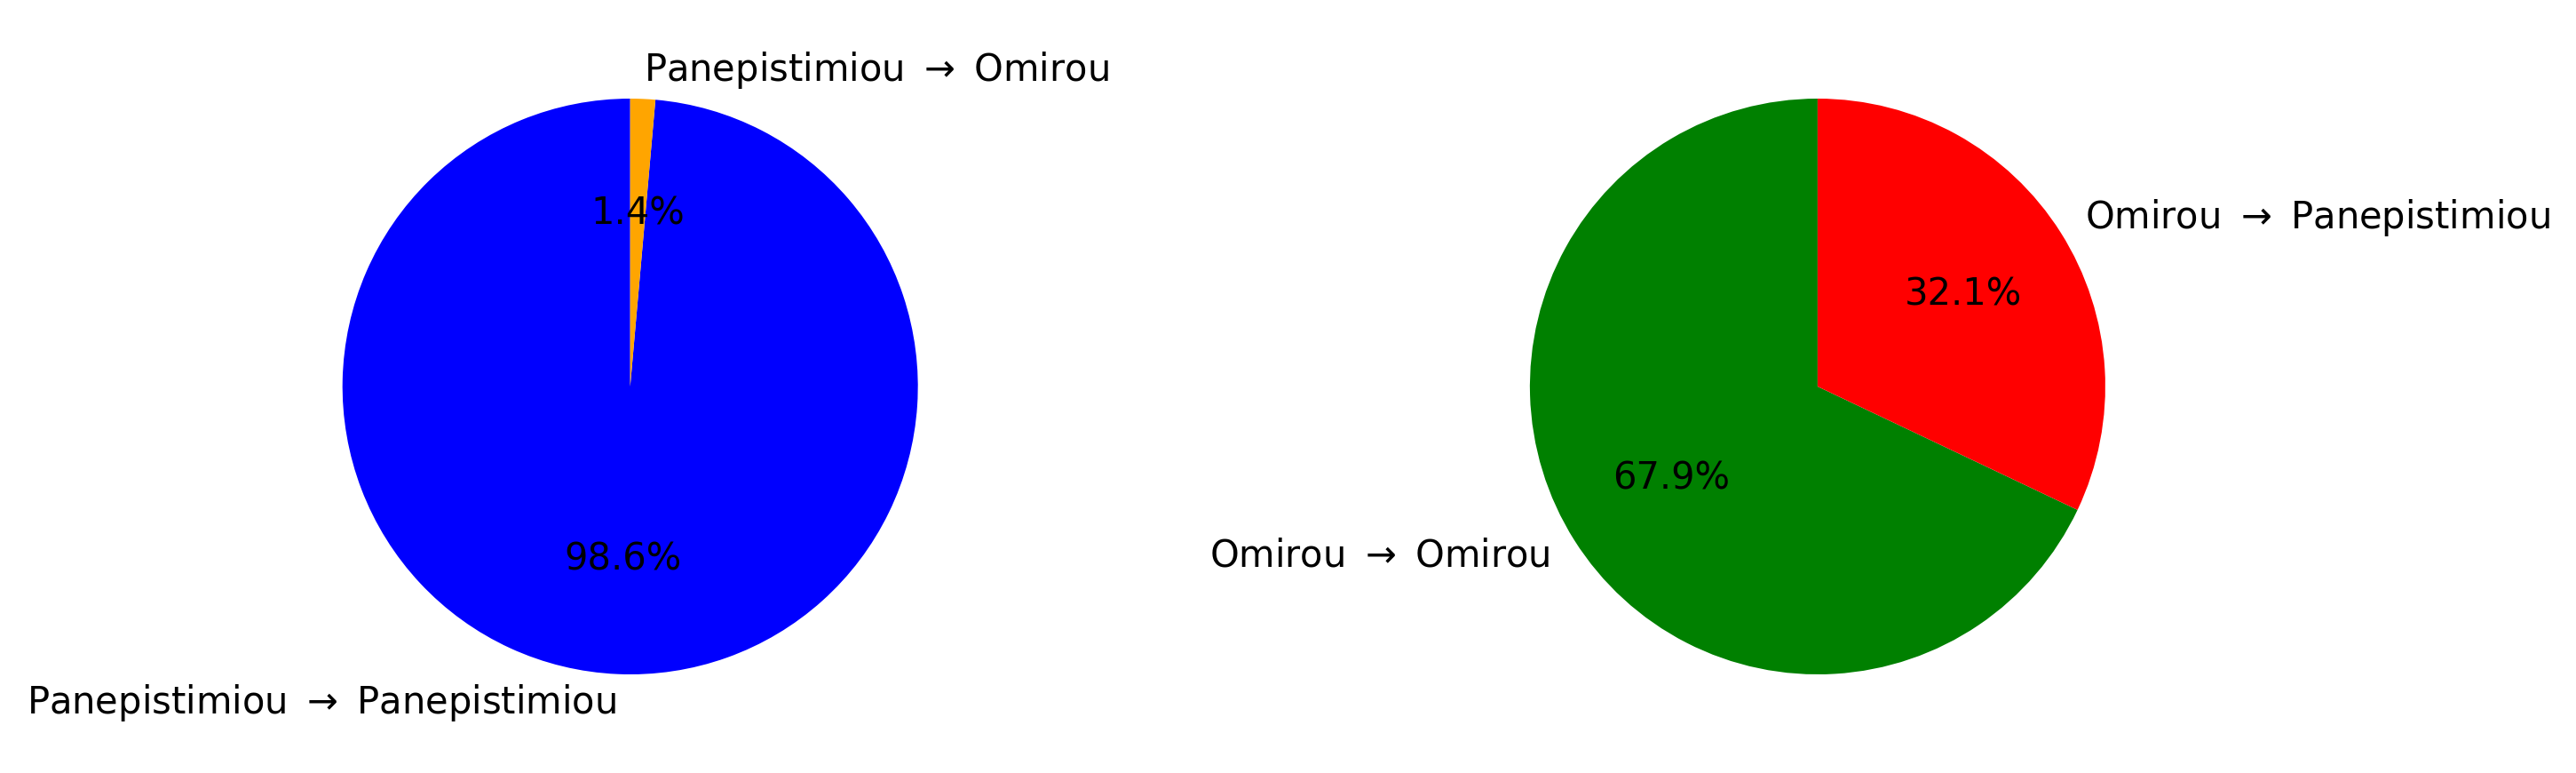

In [29]:
fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(10,3),dpi=300)

labels_13_12 = [r'Panepistimiou $\to$ Panepistimiou', r'Panepistimiou $\to$ Omirou']
sizes_13_12 = [100*sum([1 for pair in od_pairs if pair in [(1,3)]])/(len(od_pairs)), 100*sum([1 for pair in od_pairs if pair in [(1,2)]])/(len(od_pairs))]

#ax[0].set_title('Turn ratios for trajectories originating from Panepistimiou Ave.')
ax[0].pie(sizes_13_12,labels=labels_13_12,colors=['blue','orange'],autopct='%1.1f%%', startangle=90)

labels_43_42 = [r'Omirou $\to$ Omirou',r'Omirou $\to$ Panepistimiou']
sizes_43_42 = [100*sum([1 for pair in od_pairs if pair in [(4,2)]])/(len(od_pairs)), 100*sum([1 for pair in od_pairs if pair in [(4,3)]])/(len(od_pairs))]

#ax[1].set_title('Turn ratios for trajectories originating from Omirou Str.')
ax[1].pie(sizes_43_42,labels=labels_43_42,colors=['green','red'],autopct='%1.1f%%', startangle=90)


plt.tight_layout()
plt.show(close=True)

In [8]:
data_13_12 = analysis.get_od_data(desirable_pairs=[(1,3),(1,2)])
analysis_13_12 = tool.analysis(data_13_12,spatio_temporal_info)
visual_13_12 = tool.visualization(data_13_12,spatio_temporal_info)
#----------------------------------------------------------------------
data_43_42 = analysis.get_od_data(desirable_pairs=[(4,3),(4,2)])
analysis_43_42 = tool.analysis(data_43_42,spatio_temporal_info)
visual_43_42 = tool.visualization(data_43_42,spatio_temporal_info)

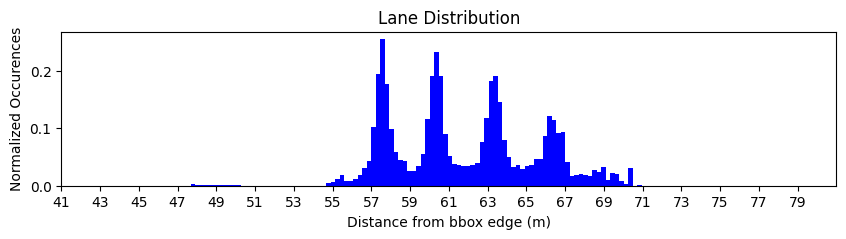

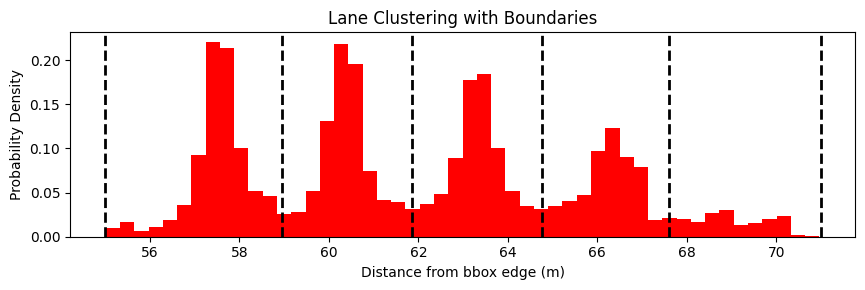

In [9]:
lane_info_13_12 = analysis_13_12.get_lane_info(flow_direction='up',nbins=100,valid_od_pairs=[(1,3)],avg_d_from_bbox_edge=False,custom_boundaries=False)

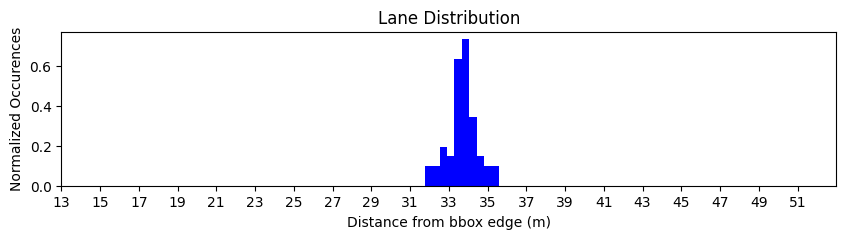

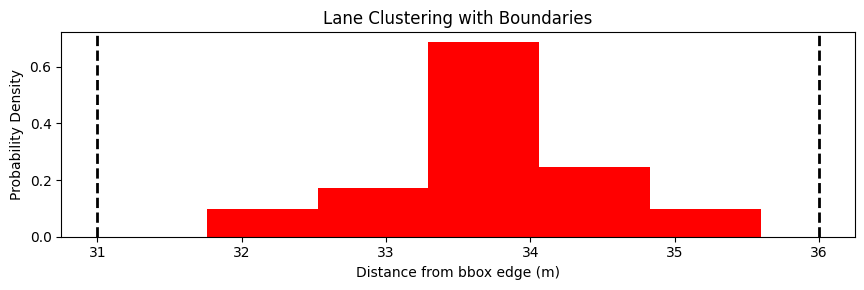

In [10]:
lane_info_43_42 = analysis_43_42.get_lane_info(flow_direction='left',nbins=10,valid_od_pairs=[(4,2)],avg_d_from_bbox_edge=True)

In [11]:
sorted_id_13_12 = analysis_13_12.get_sorted_id()
gaps_13_12 = analysis_13_12.get_gaps()
#==============================================
sorted_id_43_42 = analysis_43_42.get_sorted_id()
gaps_43_42 = analysis_43_42.get_gaps()

In [12]:
detector_positions_13_12 = (37.978572395827086, 23.734345599162733)
#---------------------------
flow_info_13_12 = analysis_13_12.get_flow_info(detector_positions_13_12)
flow_13_12,norm_flow_13_12 = analysis_13_12.get_normalized_flow(threshold=10)
#============================
detector_positions_43_42 = (37.97876743300198, 23.734464957457945)
#----------------------------
flow_info_43_42 = analysis_43_42.get_flow_info(detector_positions_43_42)
flow_43_42,norm_flow_43_42 = analysis_43_42.get_normalized_flow(threshold=15)

In [13]:
print(f'flow counts main: {sum(flow_13_12)}, max vehicles: {len(data_13_12.get('id'))}')
print(f'\nflow counts secondary: {sum(flow_43_42)}, max vehicles: {len(data_43_42.get('id'))}')

flow counts main: 1001, max vehicles: 1001

flow counts secondary: 78, max vehicles: 78


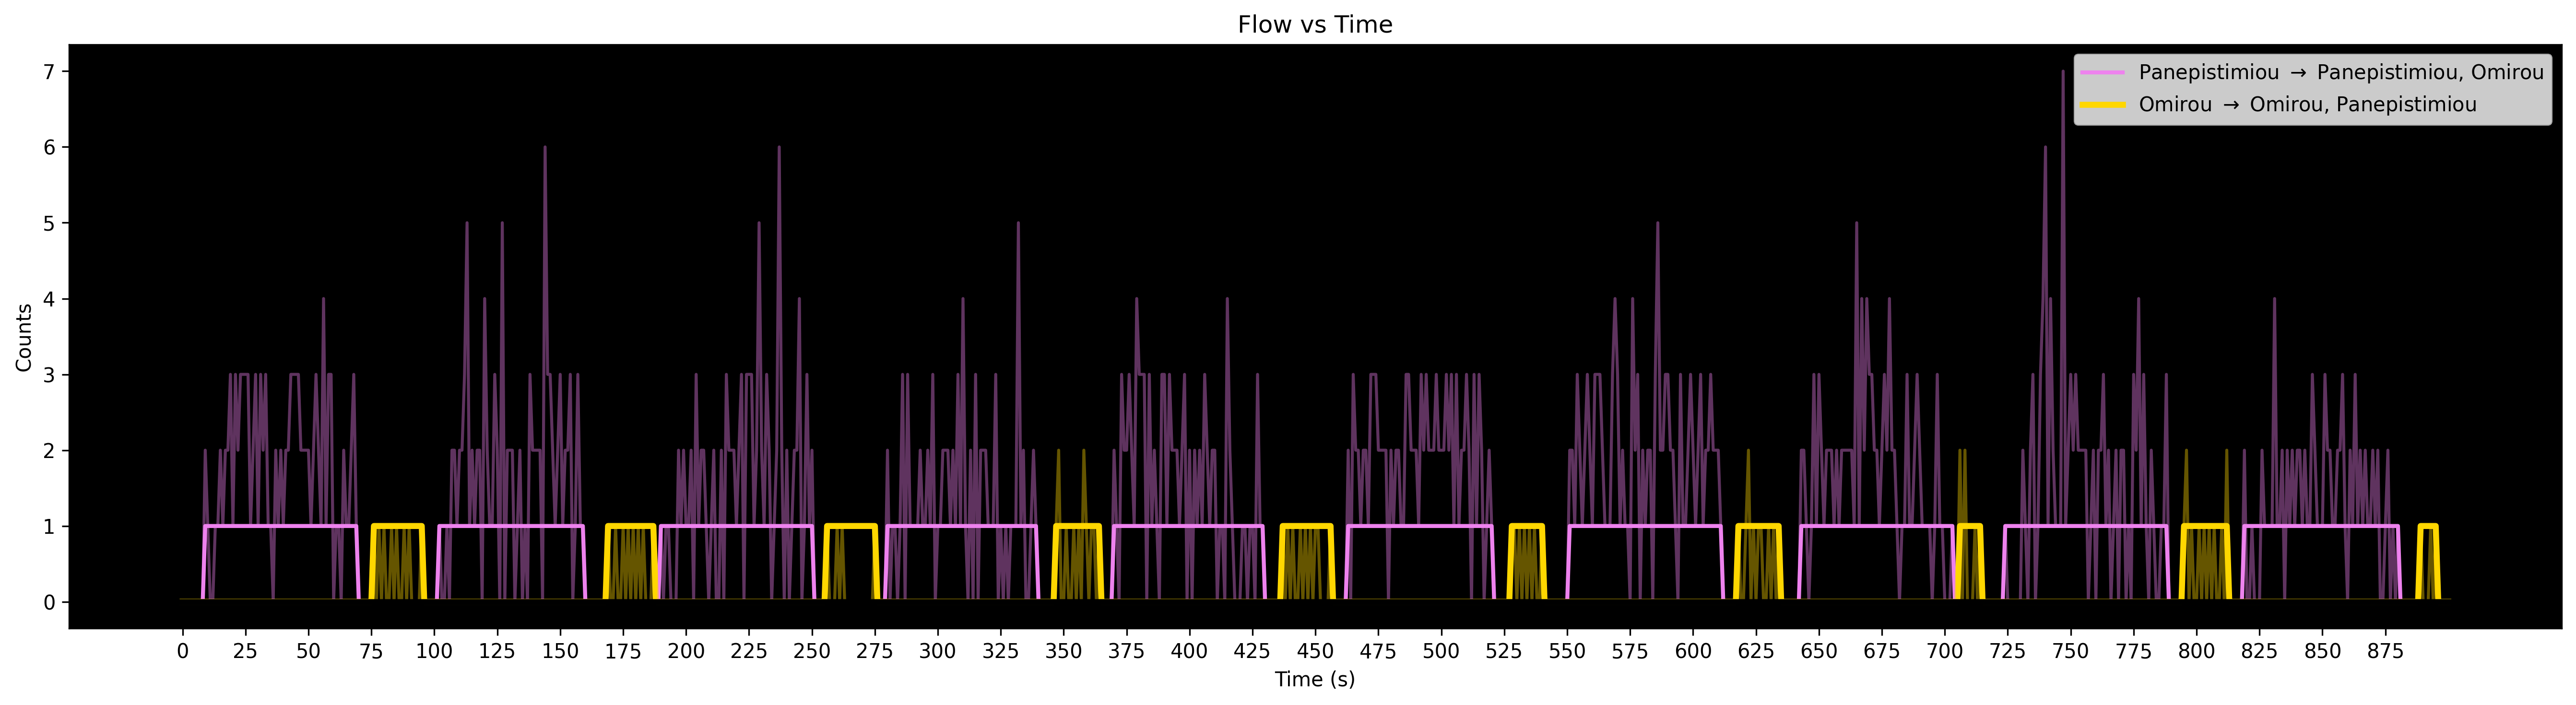

In [40]:
legend_13_12=r'Panepistimiou $\to$ Panepistimiou, Omirou'
legend_43_42=r'Omirou $\to$ Omirou, Panepistimiou'
visualization.draw_traffic_light_phases(legend_13_12,legend_43_42,norm_flow_13_12,norm_flow_43_42,flow_13_12,flow_43_42)

In [ ]:
tlp_13_12 = analysis_13_12.get_traffic_light_phases()
tlp_43_42 = analysis_43_42.get_traffic_light_phases()
#==================================================
cycles = analysis.get_traffic_light_cycles(tlp_13_12,tlp_43_42)

In [ ]:
queue_info_13_12 = analysis_13_12.get_queue_info(speed_threshold=20, gap_threshold=15)
queue_info_43_42 = analysis_43_42.get_queue_info(speed_threshold=40, gap_threshold=15)